## Find Tickers
We would like to identify cointegrated pairs.

In this example we will look at Utilities. The flow of this file is as follows

1. Read the tickers from the list we made
2. Look at only those where volume is greater than 1000000 for high liquidity
3. Drop missing values
4. Perform coint test and get those with p_value less than 0.05

In [1]:
import json
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.stattools import coint

In [3]:
filename='/Users/gabe/Desktop/FIM 500/Pairs Trading/Live_Pairs_Trading/research/manufacturing/data/industrials.csv'
df = pd.read_csv(filename, index_col = 0)
df.head()


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,CSX,CSX Corporation,31.31,0.40,+1.29%,13.026M,13.013M,62.818B,15.81,NaN
1,RTX,RTX Corporation,74.43,-0.65,-0.87%,10.48M,7.445M,108.334B,19.74,NaN
2,CNHI,CNH Industrial N.V.,12.87,0.12,+0.94%,5.785M,7.611M,17.13B,7.53,NaN
3,DAL,"Delta Air Lines, Inc.",38.88,-0.57,-1.44%,6.986M,9.527M,25.016B,8.34,NaN
4,LUV,Southwest Airlines Co.,28.52,-0.39,-1.35%,4.958M,7.391M,16.987B,30.34,NaN


In [4]:
df.shape

(100, 10)

We want to trade with stocks with adequate demand from buyers and sellers, we can eliminate others by defining a cap for the trade volume.

In [5]:
def convert_volume(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6  # Convert to millions
    elif 'k' in value:
        return float(value.replace('k', '')) * 1e3  # Convert to thousands
    else:
        return float(value)  # No conversion needed

# Apply the conversion function to the 'Volume' column
df['Volume'] = df['Volume'].apply(convert_volume)

In [6]:
# Define a volume cap
volume_cap = 1000000

df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
df['Price (Intraday)'] = pd.to_numeric(df['Price (Intraday)'], errors='coerce')

df = df[['Symbol','Volume','Price (Intraday)']].sort_values(by='Volume', ascending=False)

high_volume = df["Volume"]>volume_cap
df_h = df[high_volume]
tickers = df_h.Symbol.tolist()
tickers

['CSX',
 'RTX',
 'DAL',
 'CNHI',
 'LUV',
 'UAL',
 'GE',
 'BA',
 'VRT',
 'TXT',
 'FDX',
 'JCI',
 'CARR',
 'CPRT',
 'RYCEY',
 'IR',
 'ZTO',
 'MMM',
 'CAT',
 'HON',
 'UPS',
 'UNP',
 'AER',
 'FAST',
 'XYL',
 'EMR',
 'GFL',
 'PAYX',
 'PCAR',
 'MAS',
 'NSC',
 'HWM',
 'TRU',
 'OTIS',
 'DE',
 'RBA',
 'CP',
 'ETN',
 'ADP',
 'WM',
 'LMT',
 'FERG']

## Download Price Data
We will use yfinance (https://pypi.org/project/yfinance/) to download the closing prices of stocks. More information is available on the next notebook which we will download and save a more detailed stock data.

In [7]:
# Enable to use start & end dates:
start = datetime.date.today() - datetime.timedelta(days=430)
end = datetime.date.today() - datetime.timedelta(days=60)

df = yf.download(tickers, start, end)["Close"]

df.info()

[*********************100%%**********************]  42 of 42 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-07-26 to 2023-07-28
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADP     254 non-null    float64
 1   AER     254 non-null    float64
 2   BA      254 non-null    float64
 3   CARR    254 non-null    float64
 4   CAT     254 non-null    float64
 5   CNHI    254 non-null    float64
 6   CP      254 non-null    float64
 7   CPRT    254 non-null    float64
 8   CSX     254 non-null    float64
 9   DAL     254 non-null    float64
 10  DE      254 non-null    float64
 11  EMR     254 non-null    float64
 12  ETN     254 non-null    float64
 13  FAST    254 non-null    float64
 14  FDX     254 non-null    float64
 15  FERG    254 non-null    float64
 16  GE      254 non-null    float64
 17  GFL     254 non-null    float64
 18  HON     254 non-null    float64
 19  HWM     254 non-null   

Check for null values and eliminate them It is important to check the dataframe for Na rows & columns before moving forward. Downloaded data may not be consistent all the time, so better doing it manually before proceeding:

In [9]:
df.head()

,ADP,AER,BA,CARR,CAT,CNHI,CP,CPRT,CSX,DAL,...,RYCEY,TRU,TXT,UAL,UNP,UPS,VRT,WM,XYL,ZTO
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-26,217.910004,43.230000,155.919998,38.090000,181.229996,11.61,74.589996,29.912500,31.160000,30.639999,...,1.10,75.519997,63.720001,35.340000,215.970001,181.529999,10.25,155.009995,84.919998,26.150000
2022-07-27,234.039993,44.740002,156.089996,39.540001,185.250000,11.92,76.959999,30.707500,31.830000,31.500000,...,1.12,75.440002,65.199997,36.419998,219.889999,183.899994,10.50,159.300003,87.239998,26.290001
2022-07-28,239.479996,44.709999,159.089996,39.480000,187.839996,12.15,77.599998,31.442499,31.709999,31.700001,...,1.11,78.779999,64.779999,36.740002,223.740005,188.240005,10.98,164.570007,89.980003,26.389999
2022-07-29,241.119995,44.860001,159.309998,40.529999,198.250000,12.92,78.870003,32.025002,32.330002,31.799999,...,1.13,79.230003,65.639999,36.750000,227.300003,194.889999,11.42,164.559998,92.029999,25.590000
2022-08-01,241.320007,44.279999,169.070007,40.570000,194.860001,12.45,77.849998,32.215000,32.599998,32.230000,...,1.14,77.529999,65.760002,37.689999,227.080002,195.339996,11.45,163.360001,91.199997,25.200001


In [16]:
df = df.dropna(axis=0, how='all') # check if necessary
df = df.dropna(axis=1) # check if necessary
new_tickers = df.columns.tolist()
print(f"we have {len(new_tickers)} tickers left")
file_name = "/Users/gabe/Desktop/FIM 500/Pairs Trading/Live_Pairs_Trading/research/manufacturing/data/industrials_close_prices.pkl"
df.to_pickle(file_name)
df.info()

we have 42 tickers left
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-07-26 to 2023-07-28
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADP     254 non-null    float64
 1   AER     254 non-null    float64
 2   BA      254 non-null    float64
 3   CARR    254 non-null    float64
 4   CAT     254 non-null    float64
 5   CNHI    254 non-null    float64
 6   CP      254 non-null    float64
 7   CPRT    254 non-null    float64
 8   CSX     254 non-null    float64
 9   DAL     254 non-null    float64
 10  DE      254 non-null    float64
 11  EMR     254 non-null    float64
 12  ETN     254 non-null    float64
 13  FAST    254 non-null    float64
 14  FDX     254 non-null    float64
 15  FERG    254 non-null    float64
 16  GE      254 non-null    float64
 17  GFL     254 non-null    float64
 18  HON     254 non-null    float64
 19  HWM     254 non-null    float64
 20  IR      254 non-null    float64
 

## Find Cointegrated Pairs
We will perfom cointegration tests for all of the pairs that we can produce from the available tickers. We still need to perform more detailed tests for stationarity in the following notebooks.

This function is designed to perform a statistical test called a cointegration test on a set of financial data, which typically represents the price movements of different assets or financial instruments (often referred to as "tickers"). Let me break down what this function does step by step:

def cointegration_test(data, p_value=0.05):: This line defines a Python function called cointegration_test that takes two inputs: data and p_value. data is expected to be a dataset containing historical price or return data for multiple financial instruments (tickers), and p_value is a significance level used in the test, with a default value of 0.05 (commonly used in statistical testing).

n = data.shape[1]: This line calculates the number of columns (or financial instruments) in the input dataset data and assigns it to the variable n.

stats = np.zeros((n, n)) and pvalues = np.ones((n, n)): These lines create two empty matrices (stats and pvalues) with dimensions n by n, where n is the number of financial instruments. These matrices will be filled with statistical results later.

keys = data.keys(): This line retrieves the names of the columns (financial instruments) in the input dataset and stores them in the keys variable.

pairs = []: This initializes an empty list called pairs. This list will store pairs of financial instruments that show significant cointegration.

The following nested for loops iterate through all possible combinations of financial instruments (tickers):

for i in range(n):: This loop selects one financial instrument (ticker) as the first in a pair. for j in range(i+1, n):: This nested loop selects a different financial instrument as the second in a pair. The use of i+1 ensures that each pair is unique (e.g., it won't consider the same pair twice). result = coint(data[keys[i]], data[keys[j]]): For each pair of financial instruments selected in the loops, this line calculates the cointegration test statistics and p-value using a function called coint. It compares the historical price or return data of the two instruments to see if they are cointegrated.

test_stat = result[0] and pvalue = result[1]: These lines extract the test statistic and p-value from the result of the cointegration test.

stats[i, j] = test_stat and pvalues[i, j] = pvalue: These lines store the test statistic and p-value in the corresponding positions in the stats and pvalues matrices.

if pvalue < p_value:: This line checks if the calculated p-value is less than the significance level (p_value). If it is, it means that the pair of financial instruments is statistically significant in terms of cointegration.

pairs.append((keys[i], keys[j])): If the pair is statistically significant, it is added to the pairs list, which keeps track of all such pairs.

Finally, the function returns three things:

stats: A matrix containing the cointegration test statistics for all pairs of financial instruments. pvalues: A matrix containing the p-values for the cointegration test for all pairs. pairs: A list of pairs of financial instruments that are statistically significant in terms of cointegration. In summary, this function automates the process of testing whether pairs of financial instruments (tickers) are cointegrated, which can be useful for various quantitative trading and portfolio management strategies in finance. It collects and organizes the statistical results, making it easier for analysts and traders to identify pairs of assets that exhibit cointegration and may be suitable for trading strategies like pairs trading.



In [17]:
# let's define a function to loop through the tickers and do a cointegration test for each combination
def cointegration_test(data, p_value=0.05):
    n = data.shape[1]
    # create matrix to be filled later
    stats = np.zeros((n, n))
    pvalues = np.ones((n, n))
    keys = data.keys() # get the info axis, returns columns if object is a dataframe
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            test_stat = result[0]
            pvalue = result[1]
            stats[i, j] = test_stat
            pvalues[i, j] = pvalue

            if pvalue < p_value: # pick only statistically significant ones
                pairs.append((keys[i], keys[j]))

    return stats, pvalues, pairs

[('ADP', 'LUV'), ('AER', 'CAT'), ('AER', 'JCI'), ('CP', 'CSX'), ('CP', 'FAST'), ('CP', 'FDX'), ('CP', 'MAS'), ('CP', 'OTIS'), ('DE', 'EMR'), ('DE', 'TXT'), ('EMR', 'HON'), ('ETN', 'IR'), ('ETN', 'PCAR'), ('FAST', 'FDX'), ('FAST', 'MAS'), ('HWM', 'IR'), ('IR', 'MAS'), ('IR', 'PCAR'), ('IR', 'UAL'), ('JCI', 'XYL'), ('LMT', 'RTX'), ('LUV', 'NSC'), ('MAS', 'VRT'), ('PAYX', 'UNP')]


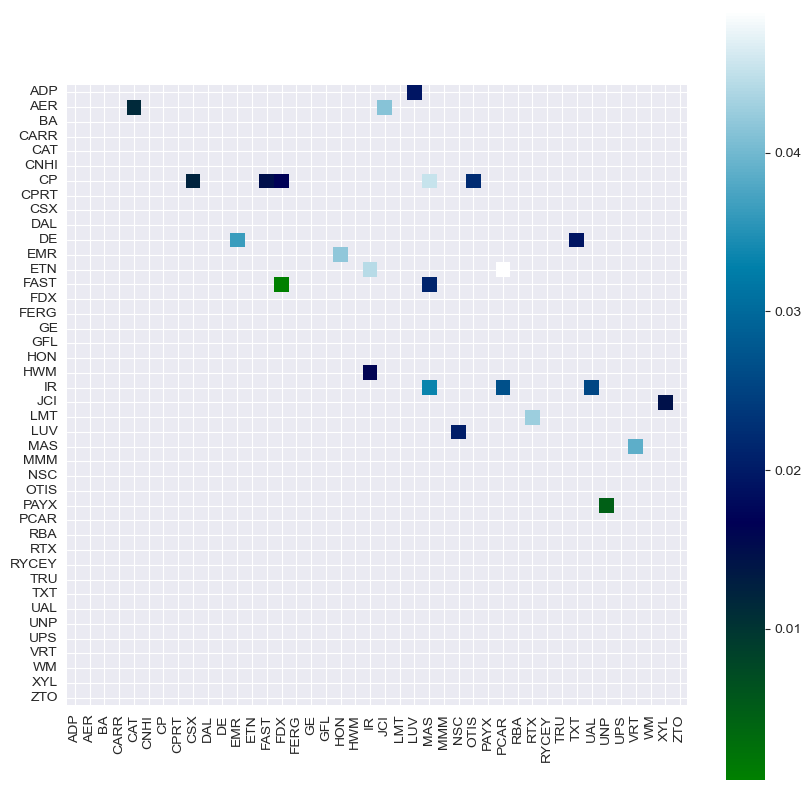

In [18]:
p_value = 0.05  # A p-value less than 0.05 is typically considered to be statistically significant

scores, pvalues, pairs = cointegration_test(df,p_value)

fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    pvalues,
    xticklabels=new_tickers,
    yticklabels=new_tickers,
    cmap="ocean",
    mask=(pvalues >= 0.05),
    square=True
)
print(pairs)

Filter for more significant pairs

,CAT,CSX,EMR,FAST,FDX,HON,IR,JCI,LUV,MAS,NSC,OTIS,PCAR,RTX,TXT,UAL,UNP,VRT,XYL
ADP,nan,nan,nan,nan,nan,nan,nan,nan,0.019,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AER,0.012,nan,nan,nan,nan,nan,nan,0.041,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CP,nan,0.012,nan,0.015,0.017,nan,nan,nan,nan,0.045,nan,0.022,nan,nan,nan,nan,nan,nan,nan
DE,nan,nan,0.036,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.019,nan,nan,nan,nan
EMR,nan,nan,nan,nan,nan,0.042,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ETN,nan,nan,nan,nan,nan,nan,0.044,nan,nan,nan,nan,nan,0.049,nan,nan,nan,nan,nan,nan
FAST,nan,nan,nan,nan,0.000,nan,nan,nan,nan,0.021,nan,nan,nan,nan,nan,nan,nan,nan,nan
HWM,nan,nan,nan,nan,nan,nan,0.016,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
IR,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.033,nan,nan,0.027,nan,nan,0.026,nan,nan,nan
JCI,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.015


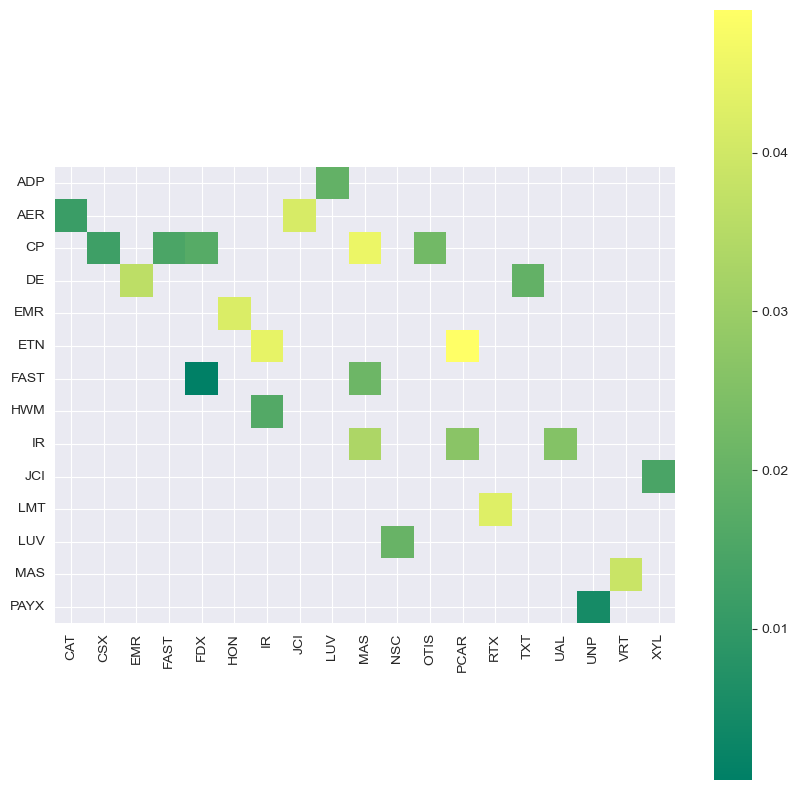

In [19]:
mask_matrix = (pvalues >= 0.05) # possible to increase the level of significance

mask_df = pd.DataFrame(mask_matrix, index= new_tickers, columns = new_tickers)
scores_df = pd.DataFrame(scores, index= new_tickers, columns = new_tickers)
pvalues_df = pd.DataFrame(pvalues, index= new_tickers, columns = new_tickers)

df_f = pvalues_df[~mask_df].dropna(how='all', axis=1)
df_f = df_f.dropna(how='all')

def gold_apply(x):
    color = {True: "background-color: #c78f2e", False: "color : white"}
    is_color = (x > 0).replace(color)
    return is_color


fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(
    df_f,
    xticklabels=df_f.columns,
    yticklabels=df_f.index,
    cmap="summer",
    square=True
)
df_f.style.format(precision=3) \
    .apply(gold_apply)

In [20]:
x_list = df_f.index.tolist()
y_list = df_f.columns.tolist()

new_pairs_list = [] # list of pairs as tuples (A,B)

for i in range(len(x_list)):
    for j in range(len(y_list)):
        if df_f.iloc[i,j]>0:
            new_pairs_list.append((x_list[i], y_list[j]))

new_pairs_list

[('ADP', 'LUV'),
 ('AER', 'CAT'),
 ('AER', 'JCI'),
 ('CP', 'CSX'),
 ('CP', 'FAST'),
 ('CP', 'FDX'),
 ('CP', 'MAS'),
 ('CP', 'OTIS'),
 ('DE', 'EMR'),
 ('DE', 'TXT'),
 ('EMR', 'HON'),
 ('ETN', 'IR'),
 ('ETN', 'PCAR'),
 ('FAST', 'FDX'),
 ('FAST', 'MAS'),
 ('HWM', 'IR'),
 ('IR', 'MAS'),
 ('IR', 'PCAR'),
 ('IR', 'UAL'),
 ('JCI', 'XYL'),
 ('LMT', 'RTX'),
 ('LUV', 'NSC'),
 ('MAS', 'VRT'),
 ('PAYX', 'UNP')]

In [21]:
new_pairs_str =[] # list of pairs as string A-B

for column in df_f:
    toprint = df_f.index[df_f[column]>0].tolist()
    new_pairs_str.append([column + "-" + s for s in toprint])

new_pairs_str

[['CAT-AER'],
 ['CSX-CP'],
 ['EMR-DE'],
 ['FAST-CP'],
 ['FDX-CP', 'FDX-FAST'],
 ['HON-EMR'],
 ['IR-ETN', 'IR-HWM'],
 ['JCI-AER'],
 ['LUV-ADP'],
 ['MAS-CP', 'MAS-FAST', 'MAS-IR'],
 ['NSC-LUV'],
 ['OTIS-CP'],
 ['PCAR-ETN', 'PCAR-IR'],
 ['RTX-LMT'],
 ['TXT-DE'],
 ['UAL-IR'],
 ['UNP-PAYX'],
 ['VRT-MAS'],
 ['XYL-JCI']]

In [22]:
new_pairs_dic= {} # list of pairs as dictionary {'A':['B','C']}

for column in df_f:
    new_pairs_dic[column] = df_f.index[df_f[column]>0].tolist()

new_pairs_dic

{'CAT': ['AER'],
 'CSX': ['CP'],
 'EMR': ['DE'],
 'FAST': ['CP'],
 'FDX': ['CP', 'FAST'],
 'HON': ['EMR'],
 'IR': ['ETN', 'HWM'],
 'JCI': ['AER'],
 'LUV': ['ADP'],
 'MAS': ['CP', 'FAST', 'IR'],
 'NSC': ['LUV'],
 'OTIS': ['CP'],
 'PCAR': ['ETN', 'IR'],
 'RTX': ['LMT'],
 'TXT': ['DE'],
 'UAL': ['IR'],
 'UNP': ['PAYX'],
 'VRT': ['MAS'],
 'XYL': ['JCI']}

In [23]:
df_f.to_pickle("/Users/gabe/Desktop/FIM 500/Pairs Trading/Live_Pairs_Trading/research/manufacturing/data/pairs_to_download.pkl")

In [24]:
new_pairs_dic

{'CAT': ['AER'],
 'CSX': ['CP'],
 'EMR': ['DE'],
 'FAST': ['CP'],
 'FDX': ['CP', 'FAST'],
 'HON': ['EMR'],
 'IR': ['ETN', 'HWM'],
 'JCI': ['AER'],
 'LUV': ['ADP'],
 'MAS': ['CP', 'FAST', 'IR'],
 'NSC': ['LUV'],
 'OTIS': ['CP'],
 'PCAR': ['ETN', 'IR'],
 'RTX': ['LMT'],
 'TXT': ['DE'],
 'UAL': ['IR'],
 'UNP': ['PAYX'],
 'VRT': ['MAS'],
 'XYL': ['JCI']}

In [25]:
# Define the file path
file_path = "/Users/gabe/Desktop/FIM 500/Pairs Trading/Live_Pairs_Trading/research/manufacturing/data/pairs_names.json"

# Save the dictionary to the JSON file
with open(file_path, "w") as json_file:
    json.dump(new_pairs_dic, json_file)